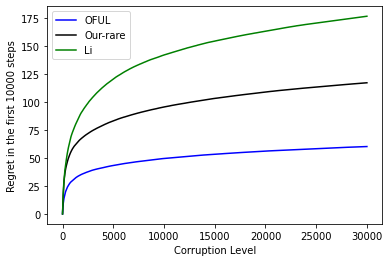

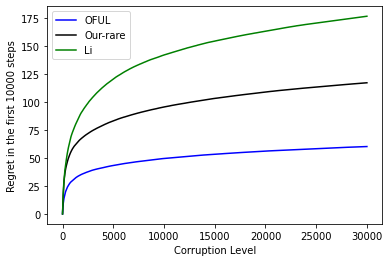

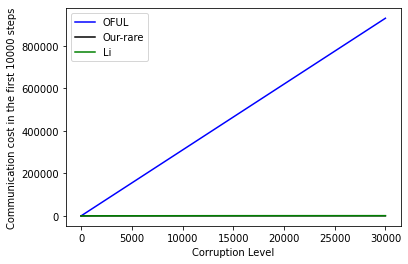

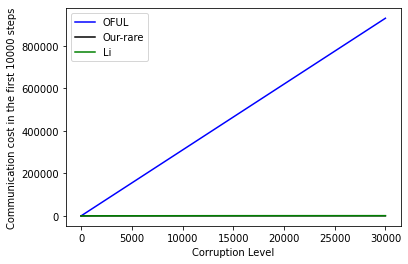

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import os
import argparse
import random
import math
import json
import numpy as np
import scipy
import matplotlib.pylab as plt
#import torch
import math
import copy
import random
import os
#import cvxpy as cp
from random import randrange


# In[2]:


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--hidden-dim", default = 20, type = int)
    parser.add_argument("--range", default = .5, type = float)
    parser.add_argument("--corruption-level", default = 0, type = float)
    parser.add_argument("--num-rounds", default = 10000, type = int)
    parser.add_argument("--num-trials", default = 10, type = int)
    parser.add_argument("--seed", type=int, default = 201912)
    parser.add_argument("--norm-a", default = 1., type = float)
    parser.add_argument("--norm-b", default = 1., type = float)
    parser.add_argument("--num-actions", default = 20, type = int)
    args = parser.parse_args()
    return args


# In[3]:


def init_vector(dim, norm):
    vec = 2 * np.random.rand(dim) - 1.
    return vec * norm / math.sqrt(dim)


# In[4]:


def init_arms(dim, norm, num):
    decision = np.random.rand(num, dim)
    for i in range(num):
        decision[i] = init_vector(dim, norm)
    return decision


# In[5]:


#dim = 10
dim = 15
sigma= 0.3
#T= 1000
T = 30000
repeat = 20
actions = 25
norm = 1
M=30
#M = 10

#mu = np.ones(dim)/ math.sqrt(dim)
bmu = np.random.rand(dim)
bmu = bmu/ np.linalg.norm(bmu)

# In[ ]:


for jjjj in range(repeat):
    ############FIXED-DECISION-SET###################
    #print(jjjj)
    cur_crr = 0
    decision_fix = np.zeros((M, actions , dim))
    for t in range(M):
        decision_fix[t]= init_arms(dim, norm, actions)
    ############SINGLE-OFUL(Full-communication)###################
    LAMBDA = 1
    beta=0.5
    alpha=1
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    COST = 0
    TOTALCOST = []
    for t in range(T):
        noise=np.random.randn(actions) * sigma
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += optimal_reward - np.dot(action, bmu)
        SIGMA[:,:]  = SIGMA[:,:] + np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
        COST += (M+1)
        TOTALCOST.append(COST)
    path  = "OFUL_lowerbound_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    path  = "OFUL_cost_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALCOST:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    


# In[ ]:


communication_ourrare = np.zeros(repeat)
for jjjj in range(repeat):
    ############FIXED-DECISION-SET###################
    #print(jjjj)
    cur_crr = 0
    decision_fix = np.zeros((M, actions , dim))
    for t in range(M):
        decision_fix[t]= init_arms(dim, norm, actions)
    ############Our-rare###################
    LAMBDA = 1
    beta=0.5
    alpha=1
    gamma=1
    BBDOW = np.zeros((dim, M))
    BBLOC = np.zeros((dim, M))
    BBSER = np.zeros(dim)
    BB = np.zeros((dim, M))
    SIGMADOW = np.zeros((dim, dim, M))
    SIGMALOC = np.zeros((dim, dim, M))
    SIGMASER = LAMBDA*np.diag(np.ones(dim))
    SIGMA = np.zeros((dim, dim, M))
    COST = 0
    TOTALCOST = []
    for agent in range(M):
        SIGMA[:,:,agent] = LAMBDA*np.diag(np.ones(dim))
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        agent=np.random.choice(M)
        noise=np.random.randn(actions) * sigma
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMADOW[:,:,agent], BBDOW[:,agent], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMADOW[:,:,agent], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += optimal_reward - np.dot(action, bmu)
        SIGMALOC[:,:,agent]  = SIGMALOC[:,:,agent] + np.mat(action).T * np.mat(action)
        BBLOC[:,agent] = BBLOC[:,agent] + reward[final_a_t] * action
        SIGMA[:,:,agent] = SIGMALOC[:,:,agent] + SIGMADOW[:,:,agent] 
        BB[:,agent] = BBLOC[:,agent] + BBDOW[:,agent] 
        TOTALREGRET.append(REGRET)
            ############Communication Rule###################
        if (np.linalg.det(SIGMA[:,:,agent])>(1+alpha)*np.linalg.det(SIGMADOW[:,:,agent])):
            communication_ourrare[jjjj] = communication_ourrare[jjjj] + 2
            COST += 2
            SIGMASER = SIGMASER + SIGMALOC[:,:,agent]
            BBSER = BBSER + BBLOC[:,agent]
            SIGMADOW[:,:,agent] = SIGMASER
            BBDOW[:,agent] = BBSER
            SIGMALOC[:,:,agent] = np.zeros((dim,dim))
            BBLOC[:,agent] = np.zeros(dim)
        TOTALCOST.append(COST)
    path  = "Ourrare_lowerbound_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    path  = "Ourrare_cost_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALCOST:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 


# In[ ]:


communication_li = np.zeros(repeat) 
for jjjj in range(repeat):
    ############FIXED-DECISION-SET###################
    #print(jjjj)
    cur_crr = 0
    decision_fix = np.zeros((M, actions , dim))
    COST = 0
    TOTALCOST = []
    for t in range(M):
        decision_fix[t]= init_arms(dim, norm, actions)
    ############Li###################
    LAMBDA = 1
    beta=0.5
    alpha=1
    gamma=1
    gamma1=5
    gamma2=5
    BBDOW = np.zeros((dim, M))
    BBLOC = np.zeros((dim, M))
    BBSER = np.zeros(dim)
    BB = np.zeros((dim, M))
    SIGMADOW = np.zeros((dim, dim, M))
    SIGMALOC = np.zeros((dim, dim, M))
    SIGMASER = LAMBDA*np.diag(np.ones(dim))
    SIGMA = np.zeros((dim, dim, M))
    for agent in range(M):
        SIGMA[:,:,agent] = LAMBDA*np.diag(np.ones(dim))
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        agent=np.random.choice(M)
        noise=np.random.randn(actions) * sigma
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        #print(SIGMA[:,:,agent]-SIGMASER[:,:], BB[:,agent]-BBSER[:])
        hattheta = np.linalg.lstsq(SIGMA[:,:,agent], BB[:,agent], rcond=-1)
        #hattheta = np.linalg.lstsq(SIGMASER[:,:], BBSER[:], rcond=-1)
        #hattheta = np.linalg.lstsq((SIGMA[:,:,agent]-SIGMALOC[:,:,agent]), (BB[:,agent]-BBLOC[:,agent]), rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:,agent], action_t, rcond=-1)
            #UU=np.linalg.lstsq(SIGMASER[:,:], action_t, rcond=-1)
            #UU=np.linalg.lstsq((SIGMA[:,:,agent]-SIGMALOC[:,:,agent]), action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += optimal_reward - np.dot(action, bmu)
        SIGMALOC[:,:,agent]  = SIGMALOC[:,:,agent] + np.mat(action).T * np.mat(action)
        SIGMA[:,:,agent]  = SIGMA[:,:,agent] + np.mat(action).T * np.mat(action)
        BBLOC[:,agent] = BBLOC[:,agent] + reward[final_a_t] * action
        BB[:,agent] = BB[:,agent] + reward[final_a_t] * action 
        TOTALREGRET.append(REGRET)
            ############Communication Rule-Upload###################
        if (np.linalg.det(SIGMA[:,:,agent])>(1+gamma1)*np.linalg.det(SIGMA[:,:,agent]-SIGMALOC[:,:,agent])):
            communication_li[jjjj] = communication_li[jjjj] + 1
            COST += 1
            SIGMASER = SIGMASER + SIGMALOC[:,:,agent]
            BBSER = BBSER + BBLOC[:,agent]
            for agent1 in range(M):
                if (agent1 != agent):
                    SIGMADOW[:,:,agent1] = SIGMADOW[:,:,agent1] + SIGMALOC[:,:,agent]
                    BBDOW[:,agent1] = BBDOW[:,agent1] + BBLOC[:,agent]
            SIGMALOC[:,:,agent] = np.zeros((dim,dim))
            BBLOC[:,agent] = np.zeros(dim)
        ############Communication Rule-Download###################
        for agent1 in range(M):
            if (np.linalg.det(SIGMASER[:,:])>(1+gamma2)*np.linalg.det(SIGMASER[:,:]-SIGMADOW[:,:,agent1])):
                communication_li[jjjj] = communication_li[jjjj] + 1
                COST += 1
                SIGMA[:,:,agent1]=SIGMA[:,:,agent1]+SIGMADOW[:,:,agent1]
                BB[:,agent1] = BB[:,agent1] + BBDOW[:,agent1]
                SIGMADOW[:,:,agent1] = np.zeros((dim,dim))
                BBDOW[:,agent1] = np.zeros(dim)
        TOTALCOST.append(COST)
    path  = "Li_lowerbound_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close()
    
    path  = "Li_cost_" + str(jjjj) + ".txt"
    fr = open(path,'w')
    for i in TOTALCOST:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 


# In[ ]:


communication_li


# In[ ]:


communication_ourrare


# In[ ]:




rewardOur = np.zeros(T+1)
rewardOurrare = np.zeros(T+1)
rewardLi = np.zeros(T+1)
rewardSingle = np.zeros(T+1)
rewardOFUL = np.zeros(T+1)
finalrewardrobust = np.zeros(11)
finalrewardgreedy = np.zeros(11)
finalrewardOFUL = np.zeros(11)

for jjjj in range(repeat):
    line1=0
    path  = "OFUL_lowerbound_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOFUL[line1]=rewardOFUL[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOFUL[i] = rewardOFUL[i]/repeat

x=list(range(T))
plt.plot(x, rewardOFUL[0:T],color='blue', label='OFUL')


for jjjj in range(repeat):
    line1=0
    path  = "Ourrare_lowerbound_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOurrare[line1]=rewardOurrare[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOurrare[i] = rewardOurrare[i]/repeat

x=list(range(T))
plt.plot(x, rewardOurrare[0:T],color='black', label='Our-rare')

for jjjj in range(repeat):
    line1=0
    path  = "Li_lowerbound_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardLi[line1]=rewardLi[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardLi[i] = rewardLi[i]/repeat

x=list(range(T))
plt.plot(x, rewardLi[0:T],color='green', label='Li')

plt.legend()
plt.xlabel('Corruption Level')
# naming the y axis
plt.ylabel('Regret in the first 10000 steps')
# giving a title to my graph
plt.savefig(os.path.join('01_pdf' + "test.pdf"), dpi=100)
# function to show the plot
plt.show()
fig=plt.gcf()
fig.savefig('./6666.jpg')


# In[ ]:




rewardOur = np.zeros(T+1)
rewardOurrare = np.zeros(T+1)
rewardLi = np.zeros(T+1)
rewardSingle = np.zeros(T+1)
rewardOFUL = np.zeros(T+1)
finalrewardrobust = np.zeros(11)
finalrewardgreedy = np.zeros(11)
finalrewardOFUL = np.zeros(11)

for jjjj in range(repeat):
    line1=0
    path  = "OFUL_cost_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOFUL[line1]=rewardOFUL[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOFUL[i] = rewardOFUL[i]/repeat

x=list(range(T))
plt.plot(x, rewardOFUL[0:T],color='blue', label='OFUL')


for jjjj in range(repeat):
    line1=0
    path  = "Ourrare_cost_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOurrare[line1]=rewardOurrare[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOurrare[i] = rewardOurrare[i]/repeat

x=list(range(T))
plt.plot(x, rewardOurrare[0:T],color='black', label='Our-rare')

for jjjj in range(repeat):
    line1=0
    path  = "Li_cost_" + str(jjjj)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardLi[line1]=rewardLi[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardLi[i] = rewardLi[i]/repeat

x=list(range(T))
plt.plot(x, rewardLi[0:T],color='green', label='Li')

plt.legend()
plt.xlabel('Corruption Level')
# naming the y axis
plt.ylabel('Communication cost in the first 10000 steps')
# giving a title to my graph
plt.savefig(os.path.join('03_pdf' + "test.pdf"), dpi=100)
# function to show the plot
plt.show()
fig=plt.gcf()
fig.savefig('./6666.jpg')


# In[ ]:





# In[ ]:




